# Deep learning Morpion Solitaire

In [1]:
from tqdm.notebook import trange
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from PIL import Image

In Google Colab, needs to upgrade `fastai` to newest version:

In [2]:
# !pip install --upgrade fastai

Load `fastai` library:

In [3]:
from fastai.vision.all import *
from fastai.callback.hook import *

/home/marc/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Load data

Import data when running in Google Colab:

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [5]:
# !ls -l 'gdrive/MyDrive/Colab Notebooks/'

In [6]:
# !tar -xf 'gdrive/MyDrive/Colab Notebooks/data.tar.gz'
# !ls -l

Import the data:

In [4]:
paths = ['data/run_0_cross', 'data/run_0_pipe', 'data/run_0_random']
data_grids = []
data_n = []
for path in paths:
    data = np.load(Path(path)/'grids.npy')
    data_grids += [data[i] for i in range(len(data))]
    data = np.load(Path(path)/'n.npy')
    data_n += [data[i] for i in range(len(data))]
len(data_grids), len(data_n)

(30000, 30000)

Check data shape:

In [20]:
data_grids[0].shape, data_grids[10000].shape, data_grids[20000].shape

((5, 15, 15), (5, 17, 17), (5, 17, 17))

In [11]:
data_n[0].shape

(4,)

Visualization function for grid data:

In [12]:
def visualize(grid):
    size = 3 * grid.shape[2] - 2
    im = np.empty((size, size), dtype=bool)
    im[0::3,0::3] = grid[0,:,:]
    im[1::3,0::3] = grid[1,:-1,:]
    im[2::3,0::3] = grid[1,:-1,:]
    im[0::3,1::3] = grid[2,:,:-1]
    im[0::3,2::3] = grid[2,:,:-1]
    im[1::3,1::3] = grid[3,:-1,:-1]
    im[2::3,2::3] = grid[3,:-1,:-1]
    im[1::3,2::3] = grid[4,1:,:-1]
    im[2::3,1::3] = grid[4,1:,:-1]
    return Image.fromarray(~im)

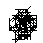

In [13]:
visualize(data_grids[0])

In [14]:
data_n[0]

array([13.6       ,  1.11355287, 16.        , 16.        ])

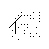

In [15]:
visualize(data_grids[-2])

In [16]:
data_n[-2]

array([28.7       , 26.83300207, 69.        , 31.        ])

Maximum values of `n`:

In [17]:
np.max([n[2] for n in data_n])

89.0

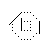

In [18]:
visualize(data_grids[np.argmax([n[2] for n in data_n])])

# DataLoaders

In [19]:
dataframe = pd.DataFrame(zip(data_grids, data_n), columns = ['grid', 'n']) 

The `x` value is a 32x32 grid, with the actual grid loaded from the dataframe inserted at a random position:

In [30]:
def get_x(data):
    grid = data['grid']
    c, w, h = grid.shape
    if w < 17:
        px = np.random.randint(17 - w)
    else:
        px = 0
    if h < 17:
        py = np.random.randint(17 - h)
    else:
        py = 0
    x = torch.zeros((c, 17, 17))
    x[:,px:px+w,py:py+h] = torch.tensor(grid)
    return x

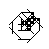

In [36]:
visualize(dataframe['grid'].iloc[12345])

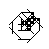

In [37]:
visualize(get_x(dataframe.iloc[12345]))

The `y` value is a 2-plet containing the maximum of `n` and its standard deviation

In [39]:
def get_y(data):
    return (torch.tensor(data['n'][2]).float(),
           torch.tensor(data['n'][1]).float())

DataBlock and DataLoaders:

In [40]:
dblock = DataBlock(get_x = get_x, get_y = get_y)

In [41]:
dls = dblock.dataloaders(dataframe, bs = 250)

Check one batch:

In [42]:
x_batch, y_batch = dls.one_batch()
x_batch.shape, y_batch[0].shape, y_batch[1].shape

(torch.Size([250, 5, 17, 17]), torch.Size([250]), torch.Size([250]))

## Loss function and metrics

The model generically returns a real number $x$ distributed around 0. We first map this to the unit interval using the sigmoid fuction
$$ s(x) = \frac{1}{1 + e^{-x}},$$
after which $0 < s < 1$.

At the same time, $y$ is a non-negative integer (positive or zero), potentially unbounded. We map it to the unit interval using
$$
s(y) = \frac{y + 1}{y + y_*},
$$
so that $s(0) = 1/y_*$, $s(\infty) = 1)$, and $s(y_* - 2) = 0.5$. The distribution of $s$ in the unit interval depends on the choice of $y_*$. If we take $y_*$ small, say for instance $y_* = 5$, then the model will discriminate best among low values of $y$; if on the contrary we take $y_*$ big, then the model will discriminate best among large values of $y$. For now we choose an intermediate value $y_* = 10$.

To get from $x$ to $y$ directly, we can use
$$
    y = (y_* - 1) e^x - 1,
$$
or conversely
$$
    x = \log\left( \frac{y + 1}{y_* - 1} \right).
$$

For the **loss function**, we compute `s` both from the predictions and the targets and return the mean square error:

In [67]:
def mse_loss(predictions, targets):
    predictions = 1/(1 + torch.exp(-predictions))
    s = (targets[0] + 1)/(targets[0] + 10)
    return torch.square(predictions - s).mean()

For the **metrics**, we compute `y` from the model predictions, round up the result to the nearest integer and compare with the target (possibly taking into account the standard deviation given with the target):

In [92]:
def n_accuracy(inputs, targets):
    n_pred = 9 * torch.exp(inputs.squeeze(1)) - 1
    return torch.where(torch.round(n_pred - targets[0]) == 0, 1.0, 0.0).mean()

In [105]:
def n_accuracy_sigma(inputs, targets, sigma = 1):
    n_pred = 9 * torch.exp(inputs.squeeze(1)) - 1
    return torch.where(torch.abs(n_pred - targets[0]) <= sigma * targets[1], 1.0, 0.0).mean()

## Convolutional neural network

Define the network architecture:

In [121]:
net = nn.Sequential(
    nn.Conv2d(5, 50, stride = 1, kernel_size = 5, padding = 2),
    nn.ReLU(),
    nn.Conv2d(50, 100, stride = 1, kernel_size = 3, padding = 1),
    nn.ReLU(),
    nn.Conv2d(100, 200, stride = 1, kernel_size = 3, padding = 1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.Linear(200, 1)
)

In [116]:
# x_batch_pred = net(x_batch)
# n_accuracy(x_batch_pred, y_batch), n_accuracy_sigma(x_batch_pred, y_batch)

In [122]:
learn = Learner(dls, net, loss_func = mse_loss,
                metrics = [n_accuracy, n_onesigma],
                cbs = ActivationStats(with_hist = True))

In [ ]:
learn.summary()

In [ ]:
learn.lr_find()

In [35]:
doc(learn.fit_one_cycle)

In [ ]:
learn.fit_one_cycle(10, lr_max = 1.0e-2)

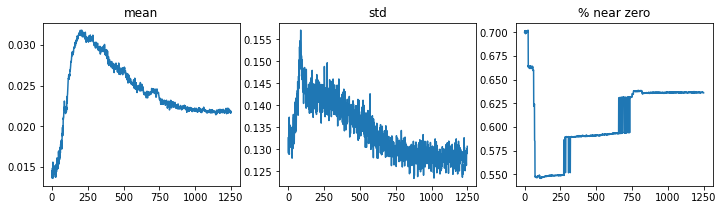

In [426]:
learn.activation_stats.plot_layer_stats(0)

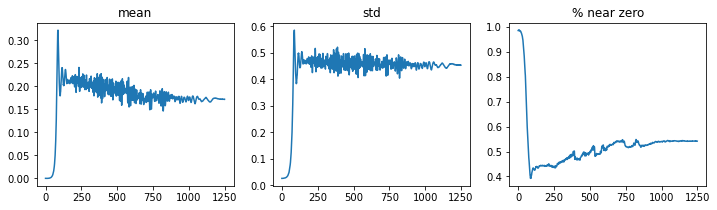

In [427]:
learn.activation_stats.plot_layer_stats(-2)

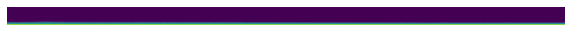

In [428]:
learn.activation_stats.color_dim(0)

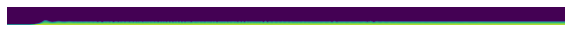

In [429]:
learn.activation_stats.color_dim(-2)

In [241]:
# learn.export(fname = 'models/cross_5T_0.pkl')

## Inference

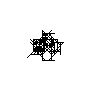

In [60]:
visualize(x_valid[0])

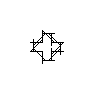

In [61]:
visualize(x_valid[1])

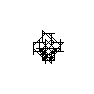

In [62]:
visualize(x_valid[2])

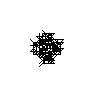

In [63]:
visualize(x_valid[3])

In [64]:
n_of_y(y_valid[0:4])

tensor([[26.0000],
        [48.0000],
        [35.0000],
        [ 3.0000]])

In [65]:
n_of_y(cnn(x_valid[0:4]).data)

TensorBase([[31.3116],
        [10.3520],
        [33.9515],
        [ 5.6773]])

In [289]:
# torch.save(cnn, 'models/test.pkl')